# Validating a recording with RIGOR criteria

In this notebook we walk you through an example of how to assess the RIGOR criteria presented in the [IBL reproducible ephys paper](https://doi.org/10.7554/eLife.100840.1) on an example recording data. Much of the code presented here is specific to data collected with Neuropixels probes using spikeglx software. Where possible we have tried to make functions allow as generic an input as possible. We hope that this acts as a guide that can then be applied to your own data.


The RIGOR criteria ("Recording Inclusion Guidelines for Optimizing Reproducibility" ) are a set of ten criteria used to assess the quality of an electrophysiological recording. They comprise a yield criterion, a noise criterion, LFP power criterion, qualitative criteria for visual assessment (lack of drift, epileptiform activity, noisy channels and artifacts), and single unit metrics (refractory period violation, amplitude cutoff, and median spike amplitude). See Table 1 in the associated [paper]((https://doi.org/10.7554/eLife.100840.1))for the full description of each criteria. 

In order to assess the RIGOR metrics on your electrophysiology data you will need access to the raw and the spikesorted data from your recording.

## Step 1: Installating compatible python environment

To get started you will need to install a python (>=3.10) environment will all the necessary packages. Below we show examples using both conda and virtual env

### Creating a new python environment
#### Using conda (recommended way)
To create a conda environment, [anaconda](https://www.anaconda.com/) must first be installed.

Once installed launch an anaconda prompt terminal and create a new conda environment. (Change the python version to the version you want to install)

`conda create --name iblenv python=3.11`

Enter yes when prompted

The new environment can be activated using,

`conda activate iblenv`

#### Using virtualenv
A new virtualenv can be created by launching a terminal and typing the following (assumes python has already been 
installed on the system)

`virtualenv iblenv --python=python3`

The new environment can be activated using,

`source ./iblenv/bin/activate`

### Install packages

With your iblenv python environment activated (`conda activate iblenv`) install the following python packages
```shell
pip install ONE-api
pip install ibllib
pip install ipython
```

## Step 2: Preparing your data

To run the RIGOR metrics you will need to have access to the raw AP and LFP band electrophysiology data and spikesorting data that has been converted into the ALF format.

<a id='probe_configuration'></a>

The code currently supports three configurations of raw data:

**Configuration 1:**
Single shank data from NP1 or NP2 single shank probes

**Configuration 2:**
Multi shank data from NP2 four shank probe - the case where data from each shank is interleaved into one recording file (the default output from spikeglx). In this case we compute the RIGOR metrics on each shank individually

**Configuration 3:**
Single shank data from NP2 four shank probe - the case where the data from each shank on a four shank probe has been split into individual files (this is the pipeline currently used in the IBL to store 4 shank data)

### Extracting LFP data
When using NP2 probes the LFP data is not saved using spikeglx and must be extracted post hoc from the full band data that has been recorded. Here we show an example of how to extract the LFP from the AP band file. 

Under the hood the code reads in the AP band data, window by window, and applies a low pass filter at 1000 Hz that acts both as an anti-aliasing filter and a low pass filter and then subsamples the data to a sampling frequency of 2500 Hz (the sampling frequency used for NP1 LFP data).

The code below only extracts the LFP data for a 600s window in the middle of the recording which will be used for the RIGOR metrics. If you want to extract the LFP data for the full recording (for example to do some other analysis on the LFP data) then set `t_interval=None`.

In [ ]:
# Import packages
from pathlib import Path
from neuropixel import NP2Converter

# Specify the path to the folder that contains your ap band data (the file ...ap.bin or ap.cbin) an associated
# ...ap.meta file should also be present in this same folder
raw_data_path = Path('path_to_your_raw_data')
ap_file = next(raw_data_path.glob('*ap.*bin'), None)
if ap_file is None:
    print('Raw ap data not found, please specify the correct folder path')


def extract_lfp(ap_file, t_interval=600):
    data_path = ap_file.parent
    # See if an lf file is already present, if it is we just return this file as we do not want to overwrite
    lf_file = next(data_path.glob('*lf.*bin'), None)
    if lf_file is not None:
        print('Raw lfp data already found, will not recompute')
        return lf_file
    
    # If an lf file is not present in the folder we extract the lfp data from the ap band file
    conv = NP2Converter(ap_file, compress=False)
    nsamples = None if t_interval is None else int(t_interval * conv.sr.fs)
    offset = None if t_interval is None else int(conv.sr.ns / 2)
    conv.init_params(nsamples=nsamples)
    conv._process_NP21(offset=offset, assert_shanks=False)
    lf_file = next(data_path.glob('*lf.*bin'), None)
    
    return lf_file

# Extact 600s of LFP data
lf_file = extract_lfp(ap_file, t_interval=600)

### Converting spikesorting data to the ALF format and computing metrics

The next preparation step is to convert the spikesorting data into the ALF format. This conversion process involves renaming the files into a standard format and most importantly converts the units of amplitude values in the spikesorting output from arbitrary units to volts. This is an important step as the single cell quality control metrics that the RIGOR metrics use have a threshold on the amplitude that is specified in volts.

To convert your spikesorting data you will need to provide the path to your raw data, your spikesorted data and also a new folder where you will want to save the converted output (this should not be the same folder as your spikesorted data).

In the code below we also compute the IBL single unit metrics on the spikesorted data that are used as part of the RIGOR criteria.

In [1]:
from ibllib.ephys import ephysqc, spikes
from ibllib.pipes.ephys_tasks import SpikeSorting
import one.alf.io as alfio
from pathlib import Path
from ibllib.ephys.spikes import ks2_to_alf
import numpy as np

raw_data_path = Path('/Users/admin/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01592/2020-10-20/001/raw_ephys_data/probe00')
ap_file = next(raw_data_path.glob('*.ap.*bin'), None)
meta_file = next(raw_data_path.glob('*.ap.*meta'), None)
spikesorting_path = Path('/Users/admin/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZFM-01592/2020-10-20/001/spike_sorters/pykilosort/probe00/ss_output')
# Path to save alf converted data, must be different from the original spikesorting data
save_path = spikesorting_path.parent.joinpath('alf_spikesorting')

# Convert to ALF format
ks2_to_alf(
    spikesorting_path,
    bin_path=raw_data_path,
    out_path=save_path,
    bin_file = ap_file,
    ampfactor=SpikeSorting._sample2v(meta_file.with_suffix('.bin')),
)

# Compute IBL metrics on converted data
spikes = alfio.load_object(save_path, 'spikes')
clusters = alfio.load_object(save_path, 'clusters')
df_units, drift = ephysqc.spike_sorting_metrics(
    spikes.times, spikes.clusters, spikes.amps, spikes.depths,
    cluster_ids=np.arange(clusters.channels.size))

df_units.to_parquet(file_metrics := save_path.joinpath("clusters.metrics.pqt"))

/Users/admin/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/alf/files.py:10: FutureWarning: `one.alf.files` will be removed in version 3.0. Use `one.alf.path` instead.
  warnings.warn(
Converting to ALF:  41%|█████████▎             | 55/135 [00:40<01:05,  1.22it/s]
Extracting waveforms:   0%|                       | 0/5503.5261 [00:00<?, ?it/s]
Extracting waveforms:   0%|             | 7.0/5503.5261 [00:00<03:03, 29.95it/s]
Extracting waveforms:   5%|▌         | 283.0/5503.5261 [00:00<00:13, 375.96it/s]
Extracting waveforms:  10%|█         | 559.0/5503.5261 [00:01<00:13, 379.11it/s]
Extracting waveforms:  15%|█▌        | 835.0/5503.5261 [00:02<00:13, 355.40it/s]
Extracting waveforms:  20%|█▊       | 1111.0/5503.5261 [00:02<00:11, 388.82it/s]
Extracting waveforms:  25%|██▎      | 1387.0/5503.5261 [00:03<00:10, 383.40it/s]
Extracting waveforms:  30%|██▋      | 1663.0/5503.5261 [00:04<00:09, 412.04it/s]
Extracting waveforms:  35%|███▏     | 1939.0/5503.5261 [00:04<00:07, 470.92

## Step 3: Define some helper functions

Here we will define some helper functions that will be used.

The first set of functions can be used to extract a snippet of one second of data at a specified time point from the AP band file or LFP band file. Note how we remove the sync channel from the data. The returned array is a 2d matrix containing the number of recording channels in the first dimension and the number of samples in the 1s interval (t_interval x sampling frequency of AP/LFP band) in the second dimension. 

We also have functions that return the sampling frequency, the recording length of the data and the geometry and arrangement of channels on the probe.

N.B These three functions are specific to data collected using spikeglx. If you have collected data using other recording software these would be the functions that will have to be reimplemented.


In [2]:
def extract_raw_data_snippet(sr, t0=1000, t_interval=1):
    # sampling frequency of data
    fs = sr.fs
    sl = slice(int(t0 * fs), int((t0 + t_interval) * fs))
    raw = sr[sl, :-sr.nsync].T
    
    return raw

def get_sampling_frequency(sr):
    return sr.fs


def get_recording_length(sr):
    return sr.rl


def get_probe_geometry(sr):
    return sr.geometry

The function below is specific to [configuration 2](#probe_configuration) where we have data from all four shanks interleaved into one data file. We want to compute the RIGOR metrics on each shank individually so we need a function that will restrict our raw data to the channels on the specified shank.

In [3]:
import neuropixel
import numpy as np

def split_data_by_shank(raw, probe_geometry, shank=0):
    chn_idx = np.where(probe_geometry['shank'] == shank)
    raw_shank = raw[:, chn_idx]
    probe_geometry_shank = neuropixel.split_trace_header(probe_geometry, shank=shank)
    
    return raw_shank, probe_geometry_shank, chn_idx

The final function reads in the spikesorting data. If you have spikesorted your data with [configuration 2](#probe_configuration), then the spikesorting output contains spikes from all shanks. If this is the case, then we can pass in the variable `chn_idx` that is output from the function `split_data_by_shank` into the `load_spike_sorting` method and it will only return the spikesorting data pertaining to channels on the shank of interest.

In [4]:
import one.alf.io as alfio

def load_spike_sorting(alf_spikesorting_path, chn_idx=None):
    spikes = alfio.load_object(alf_spikesorting_path, 'spikes')
    clusters = alfio.load_object(alf_spikesorting_path, 'clusters')
    channels = alfio.load_object(alf_spikesorting_path, 'channels')
    
    # If we need to restrict our spikesorting to only the spikesorting from a single shank (config 2)
    if chn_idx is not None:
        for k in channels.keys():
            channels[k] = channels[k][chn_idx]

        clusters_shank = np.isin(clusters.channels, channels.rawInd)
        for k in clusters.keys():
            clusters[k] = clusters[k][clusters_shank]

        spikes_shank = np.isin(spikes.clusters, clusters.metrics['cluster_id'])
        for k in spikes.keys():
            spikes[k] = spikes[k][spikes_shank]
    
    return spikes, clusters, channels

## Step 4: Visually inspecting your data

The first step of the RIGOR criteria is to visually inspect the data to look for epileptiform activity, artifacts from the acquisition hardware, severe drift on the probe, and large amounts of dead or noisy channels.

There are two main plots that are useful to explore this, a visualisation of the destriped raw data snippets and a raster plot of the spike sorting across the recording. Destriping is a process that removes artifacts from the raw data that would otherwise appear to exclude the recording. Throughout the next steps we will apply this destriping to both the raw AP and raw LFP snippets. For more information on this please refer to the [IBL's spike sorting whitepaper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522?file=49783080)

### Inspecting raw data snippets
To plot some snippets of raw data we can use the following code. Note the recording that we are using throughout the examples below is an NP1 probe so we do not need to worry about splitting our data by an individual shank. These plots are useful for looking for artifacts from the acquisition hardware and dead or noisy channels.

This recording is 5503.5261s long.


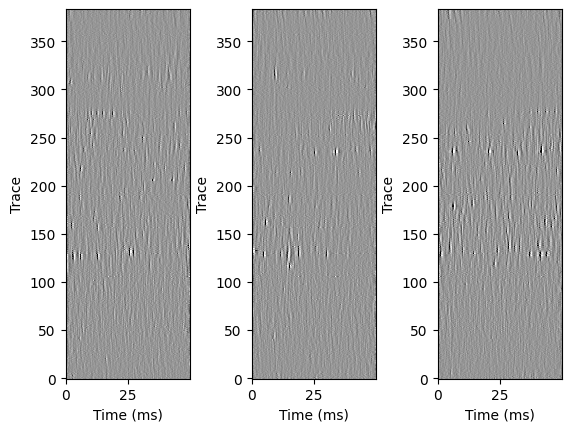

In [5]:
from ibldsp import voltage
from ibllib.plots.misc import Density
import matplotlib.pyplot as plt
import numpy as np
import spikeglx

ap_file = next(raw_data_path.glob('*ap.*bin'), None)
# Read in our raw data file
sr_ap = spikeglx.Reader(ap_file)
fs = get_sampling_frequency(sr_ap)
rl = get_recording_length(sr_ap)
probe_info = get_probe_geometry(sr_ap)

print(f"This recording is {rl}s long.")

# Pick some timepoints within the recording and display 50 ms raw data snippets
t0s = np.array([300, 1200, 2400])

fig, axs = plt.subplots(1, 3)
fig.subplots_adjust(wspace=0.5)

for i, t0 in enumerate(t0s):
    raw = extract_raw_data_snippet(sr_ap, t0=t0, t_interval=0.05)
    ap_destriped = voltage.destripe(raw, fs=fs, h=probe_info)
    Density(ap_destriped, fs=fs, ax=axs[i], taxis=1, gain=-95, title=f"T = {t0}s")

**See Fig 1, supp. 2 for examples of good and bad AP band data.**

<div class="alert alert-block alert-info"> <b>INFO</b> For config 2 the code would be as follows to split the data per shank </div>

```
raw = extract_raw_data_snippet(sr_ap, t0=t0, t_interval=0.05)
shank = 2
raw_shank, probe_info_shank = split_data_by_shank(raw, probe_info, shank=shank)
ap_destriped = voltage.destripe(raw_shank, fs=fs, h=probe_info_shank)
```

To explicitly look for dead and noisy channels the following function can be used. This reads in a raw data snippet and detects channels that are noisy, dead or that lie outside of the brain. If you find that a large number of your channels are bad, you should proceed with caution. With the `display=True` option we show a snippet of destriped raw data alongside the evaluation of the different types of noisy channels.

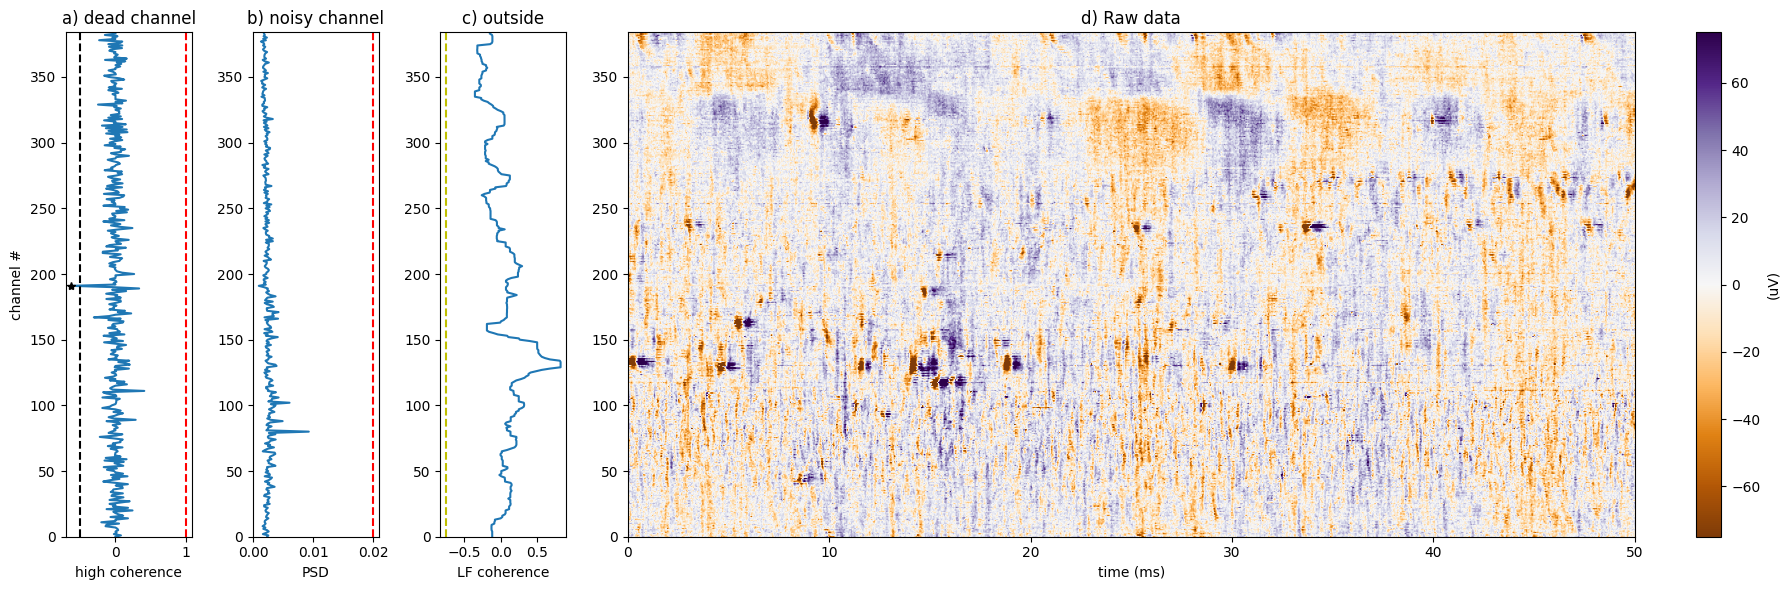

In [6]:
from ibldsp.voltage import detect_bad_channels

t0 = 1200
raw = extract_raw_data_snippet(sr_ap, t0=t0, t_interval=0.05)
channel_labels, _ = detect_bad_channels(raw, fs=fs, display=True)

### Inspecting the spike sorting raster
Another useful display is to plot the session raster plot using the spikesorted data. These plots are useful for looking for epileptiform activity, hardware artifacts and drift during the recording

Text(0.5, 0, 'Time in session (s)')

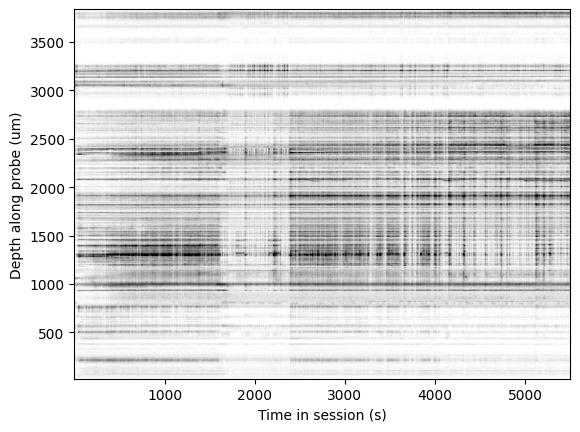

In [7]:
from brainbox.processing import bincount2D
import numpy as np
import matplotlib.pyplot as plt

spikes, clusters, channels = load_spike_sorting(save_path)

t_bin = 0.1
d_bin = 10
kp_idx = ~np.isnan(spikes.depths)
min_chn = np.min(channels.localCoordinates[:, 1])
max_chn = np.max(channels.localCoordinates[:, 1])
session_raster, t_vals, d_vals = bincount2D(spikes.times[kp_idx], spikes.depths[kp_idx],
                                            t_bin, d_bin, ylim=[min_chn, max_chn])
session_raster = session_raster / t_bin
fig, ax = plt.subplots()
ax.imshow(session_raster, extent=np.r_[np.min(t_vals), np.max(t_vals), min_chn, max_chn], aspect='auto',
                origin='lower', vmax=50, cmap='binary')
ax.set_ylabel('Depth along probe (um)')
ax.set_xlabel('Time in session (s)')

## Step 5: Raw data metrics
From the raw data we make quantitative assessments of the noise level.

### AP rms
The first criteria is the noise level of the rms of the AP band. The criteria defined is that median (across channels) AP RMS < 40 uV.

We'll estimate the RMS channel-wise by computing it on short snippets from throughout the recording. Here we take 1 second snippets every 5 minutes.

In [8]:
# This cell may take a couple of minutes to complete

from ibldsp import voltage, utils
import neuropixel
import numpy as np
import spikeglx


BATCHES_SPACING = 300 # take a sample every 300 s
TMIN = 40 # Cut off the first 40 s of data
SAMPLE_LENGTH = 1 # Take 1 s interval snippets


# Open the ap file to read data
sr_ap = spikeglx.Reader(ap_file)
# Find the full length of the recording
rl = get_recording_length(sr_ap)
# Find the sampling frequency of the data
fs = get_sampling_frequency(sr_ap)
# Extract the probe geometry
probe_info = get_probe_geometry(sr_ap)
# Extract the number of channels from the probe info
nc = probe_info['x'].size

# Compute all the times at which we will calculate the rms
t0s = np.arange(TMIN, rl - SAMPLE_LENGTH, BATCHES_SPACING)
all_rms = np.zeros((2, nc, t0s.shape[0]))

# Loop over the times, read in the raw data, destripe the raw data and compute the rms
for i, t0 in enumerate(t0s):
    raw = extract_raw_data_snippet(sr_ap, t0=t0, t_interval=SAMPLE_LENGTH)
    destripe = voltage.destripe(raw, fs=fs, h=probe_info)
    all_rms[0, :, i] = utils.rms(raw)
    all_rms[1, :, i] = utils.rms(destripe)

We computed the RMS for both the raw and destriped data. Let's see how they compare.

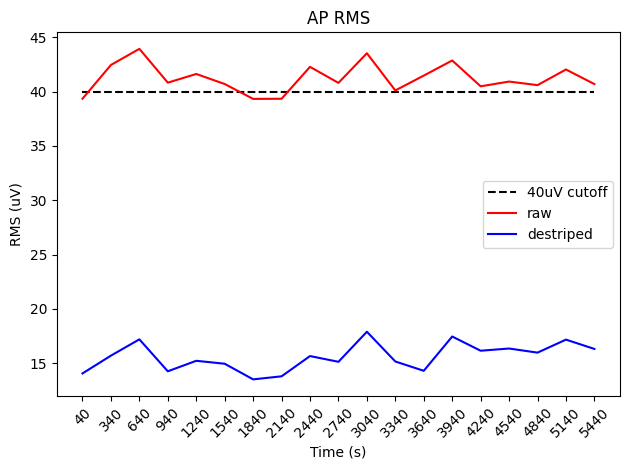

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
n_snippets = all_rms.shape[-1]

raw_rms_median = np.median(all_rms[0, :, :], axis=0)
des_rms_median = np.median(all_rms[1, :, :], axis=0)

ax.plot([0, n_snippets - 1], [40, 40], "k", ls='--', label="40uV cutoff")
ax.plot(raw_rms_median * 1e6, "r", label="raw")
ax.plot(des_rms_median * 1e6, "b", label="destriped")

ax.set_ylabel("RMS (uV)")

tick_positions = np.arange(len(t0s))
tick_labels = t0s.astype(int)
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45)

ax.set_xlabel("Time (s)")

ax.legend()
ax.set_title("AP RMS")
plt.tight_layout()

Above we can see that the RMS consistently stays below the threshold for the duration of the recording. The destriping removes certain low frequency artifacts in the time domain, leading to a lower RMS. 

In [10]:
passing_ap_rms = np.all(des_rms_median < 40*1e-6)
print(f"Passing AP rms: {passing_ap_rms}")

Passing AP rms: True


### LFP derivative

The next computed metric pertains to the LFP band. The spatial derivative of the LFP power spectrum per um should be < 0.05. Again we use destriped snippets from across the recording to estimate the power spectrum, and then estimate its spatial derivative.

In [13]:
# This cell may take 1-2 minutes to complete
import scipy.signal

LFP_RESAMPLE_FACTOR = 10
LFP_BAND = [20, 80]

BATCHES_SPACING = 500
TMIN = 40
SAMPLE_LENGTH = 20

lf_file = next(raw_data_path.glob('*lf.*bin'), None)

# Open the ap file to read data
sr_lf = spikeglx.Reader(lf_file)
# Find the full length of the recording (this may be shorter if we have only extracted 600s)
rl = get_recording_length(sr_lf)
# If we only have 600s of LFP data, make the batch spacing smaller so we extract more snippets
if rl < 700:
    BATCHES_SPACING = 100
# Find the sampling frequency of the data
fs = get_sampling_frequency(sr_lf)

# Note here the probe geometry should be obtained from the ap file, for NP1 files, the LF meta does not contain
# all the information we need
probe_info = get_probe_geometry(sr_ap)
# Extract the number of channels from the probe info
nc = probe_info['x'].size


t0s = np.arange(TMIN, rl - SAMPLE_LENGTH, BATCHES_SPACING)

for j, t0 in enumerate(t0s):
    raw = extract_raw_data_snippet(sr_lf, t0=t0, t_interval=SAMPLE_LENGTH)
    destripe = voltage.destripe_lfp(raw, fs, channel_labels=True)
    lfp = scipy.signal.decimate(destripe, LFP_RESAMPLE_FACTOR, axis=1, ftype='fir')

    f, pow = scipy.signal.periodogram(lfp, fs=250, scaling='density')
    if j == 0:
        rms_lf_band = np.zeros((lfp.shape[0], len(t0s)))

    rms_lf_band[:, j] = np.nanmean(
            10 * np.log10(pow[:, np.logical_and(f >= LFP_BAND[0], f <= LFP_BAND[1])]), axis=-1)
    lfp_power = np.nanmedian(rms_lf_band - 20 * np.log10(f[1]), axis=-1) * 2

In [15]:
def compute_gradient(lfp, h, n=1, sigma=1):
    """
    Compute the gradient of a given LFP signal recorded on neuropixel 1 or 2
    :param data: LFP signal (n_channels, n_samples)
    :param h: trace header dictionary
    :param n: the n derivative
    :param sigma: conductivity, defaults to 1 S.m-1
    :return:
    """
    csd = np.zeros(lfp.shape, dtype=np.float64) * np.nan
    xy = h["x"] + 1j * h["y"]
    for col in np.unique(h["col"]):
        ind = np.where(h["col"] == col)[0]
        isort = np.argsort(h["row"][ind])
        itr = ind[isort]
        dx = np.median(np.diff(np.abs(xy[itr])))

        sl = slice(1, -1) if n == 2 else slice(0, -1)
        csd[itr[sl], :] = (
            np.diff(lfp[itr, :].astype(np.float64), n=n, axis=0) / dx**n * sigma
        )
        csd[itr[0], :] = csd[itr[1], :]
        csd[itr[-1], :] = csd[itr[-2], :]
    return csd

# Compute gradient/um of LFP across channels, take into account channel map for different probe configurations
lfp_deriv = compute_gradient(lfp_power[:, np.newaxis], probe_info)[:, 0]

We are interested in how smoothly the LFP power varies over channels. While there are a handful of sharp spatial gradients, we can see that as a whole the value is smoothly varying for this recording.

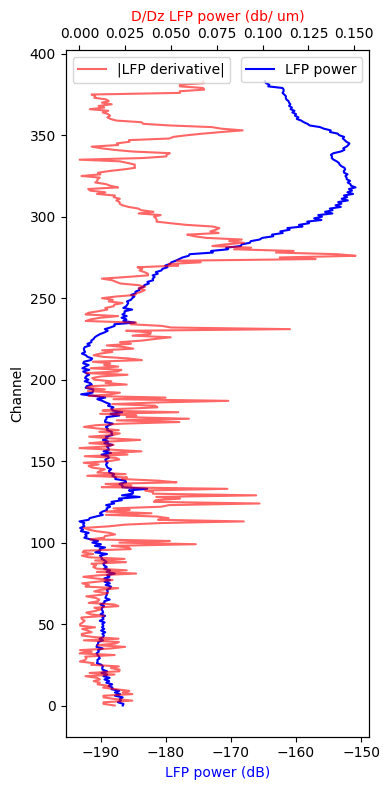

In [17]:
fig, ax = plt.subplots(figsize=(4, 8))
ax.plot(lfp_power, np.arange(nc), c="b", label="LFP power")
ax.set_ylabel("Channel")
ax.set_xlabel("LFP power (dB)", color="blue")
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.0))

ax2 = ax.twiny()
ax2.plot(np.abs(lfp_deriv), np.arange(nc), c="r", label="|LFP derivative|", alpha=0.6)
#ax2.set_xlim(0, 5)
ax2.set_xlabel("D/Dz LFP power (db/ um)", color="red")
ax2.legend(loc="upper left", bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()

Indeed if we compute the median, we see that it's <0.05 and thus satisfies the criterion.

In [18]:
lfp_deriv_med = np.median(np.abs(lfp_deriv))
lfp_passing = lfp_deriv_med < 0.05
print(f"Median LFP power derivative: {lfp_deriv_med}")
print(f"Passing: {lfp_passing}")

Median LFP power derivative: 0.019297439473104774
Passing: True


## Step 6: Spike sorting metrics

Now we turn to the RIGOR criteria pertaining to the quality of the spike sorting run.

The simplest whole recording spike sorting metric is the yield, i.e. the number of passing units recovered per channel site. We can get this from the pre-computed IBL metrics table.

In [19]:
# Load in spikesorting data

spikes, clusters, channels = load_spike_sorting(save_path)
# Find the total number of clusters
nc = clusters.metrics.label.size
neuron_yield = (clusters.metrics.label == 1).sum() / nc
yield_passing = neuron_yield > 0.1
print(f"Yield: {neuron_yield} passing units/site")
print(f"Passing: {yield_passing}")

Yield: 0.4348958333333333 passing units/site
Passing: True


### Single unit metrics

We computed the IBL metrics above to determine the yield of the recording. Now we can take a look at the individual single-unit metrics.

The sliding refractory period violation confidence level must be >90%, while the amplitude median must be > 50uV, and the noise cutoff metric < 5. See the [IBL's spike sorting whitepaper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522?file=49783080) for an in-depth discussion of the single unit metrics.

In [20]:
cols = ["max_confidence", "amp_median", "noise_cutoff"]
clusters.metrics[cols]

,max_confidence,amp_median,noise_cutoff
0,99.710716,0.000081,43.419162
1,79.628319,0.000076,70.900439
2,17.162901,0.000080,51.568304
3,90.722951,0.000072,-0.372783
4,100.000000,0.000101,8.421056
...,...,...,...
842,0.995017,0.000086,19.697980
843,0.743886,0.000036,11.437393
844,2.951707,0.000138,0.183083
845,0.399201,0.000035,25.980762


In [21]:
num_units = len(clusters.metrics)
passing_srp = sum(clusters.metrics["max_confidence"] > 90) / num_units
passing_amp = sum(clusters.metrics["amp_median"] > 50e-6) / num_units
passing_nc = sum(clusters.metrics["noise_cutoff"] < 5) / num_units
passing_all = sum(clusters.metrics["label"] == 1) / num_units

print(f"{100*passing_srp} % passing sliding refractory period violations")
print(f"{100*passing_amp} % passing amplitude median")
print(f"{100*passing_nc} % passing noise cutoff")
print(f"{100*passing_all} % passing all")

55.1357733175915 % passing sliding refractory period violations
96.45808736717828 % passing amplitude median
30.10625737898465 % passing noise cutoff
19.71664698937426 % passing all


# Step 7: Summary plot

The code below produces a summary plot of the data

(0.0, 1.0, 0.0, 1.0)

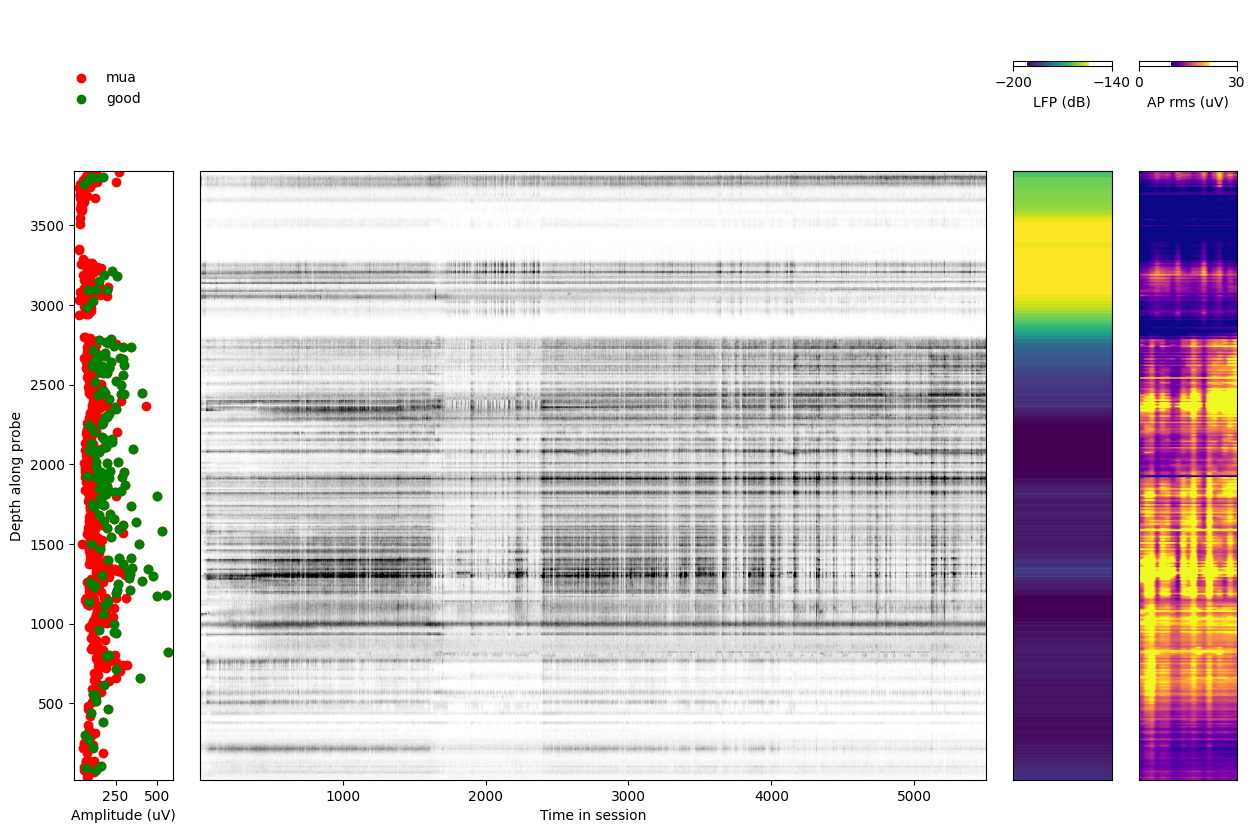

In [22]:
from matplotlib import gridspec
from brainbox.processing import compute_cluster_average

# Create the figure and set its size
fig = plt.figure(figsize=(15, 10))

# Create a main grid specification (1 row, 1 column)
gs = gridspec.GridSpec(1, 1, figure=fig, wspace=0.3, hspace=0.3)

# Create a subplot grid (2 rows, 4 columns) inside the main grid
gs0 = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[0], 
                                       width_ratios=[1, 8, 1, 1], 
                                       height_ratios=[1, 10], 
                                       wspace=0.1, hspace=0.3)

# Define individual subplot axes from the subplot grid
gs0_ax1 = fig.add_subplot(gs0[0, 0])  # Top-left corner (legend space)
gs0_ax2 = fig.add_subplot(gs0[1, 0])  # Bottom-left corner (amplitude vs depth)
gs0_ax3 = fig.add_subplot(gs0[0, 1])  # Top-center-left (empty for formatting)
gs0_ax4 = fig.add_subplot(gs0[1, 1])  # Bottom-center-left (session raster plot)
gs0_ax5 = fig.add_subplot(gs0[0, 2])  # Top-center-right (LFP colorbar space)
gs0_ax6 = fig.add_subplot(gs0[1, 2])  # Bottom-center-right (LFP plot)
gs0_ax7 = fig.add_subplot(gs0[0, 3])  # Top-right (AP RMS colorbar space)
gs0_ax8 = fig.add_subplot(gs0[1, 3])  # Bottom-right (AP RMS plot)

# Find the minimum and maximum depth coordinates from channel positions
min_chn = np.min(channels.localCoordinates[:, 1])
max_chn = np.max(channels.localCoordinates[:, 1])

# -------- CLUSTER DEPTH VS AMPLITUDE PLOT --------
# Filter out invalid depth entries (NaNs)
kp_idx = ~np.isnan(spikes.depths)

# Compute cluster-averaged depth and amplitude for valid data
_, cluster_depth, _ = compute_cluster_average(spikes.clusters[kp_idx], spikes.depths[kp_idx])
_, cluster_amp, _ = compute_cluster_average(spikes.clusters[kp_idx], spikes.amps[kp_idx])


# Identify "good" clusters (e.g., labeled as 1 in the metrics)
good_idx = np.where(clusters.metrics.label[np.isin(clusters.metrics.cluster_id,
                                                    np.unique(spikes.clusters[kp_idx]))] == 1)

# Scatter plot for MUA (red) and "good" clusters (green)
mua = gs0_ax2.scatter(cluster_amp * 1e6, cluster_depth, c='r')  # All clusters
good = gs0_ax2.scatter(cluster_amp[good_idx] * 1e6, cluster_depth[good_idx], c='g')  # Good clusters

# Add a legend for the cluster types
gs0_ax1.legend(handles=[mua, good], labels=['mua', 'good'], frameon=False, bbox_to_anchor=(0.8, 0.2))
gs0_ax1.axis('off')  # Turn off the top-left axis (used for the legend)

# Set axis labels and limits for the depth vs amplitude plot
gs0_ax2.set_xlabel('Amplitude (uV)')
gs0_ax2.set_ylabel('Depth along probe')
gs0_ax2.set_ylim(min_chn, max_chn)

# -------- SESSION RASTER PLOT --------
# Define time and depth bin sizes
t_bin = 0.1  # Time bin (in seconds)
d_bin = 10   # Depth bin (in micrometers)

# Filter valid spikes again (to exclude invalid depths)
kp_idx = ~np.isnan(spikes.depths)

# Compute a 2D histogram of spike times and depths
session_raster, t_vals, d_vals = bincount2D(spikes.times[kp_idx], spikes.depths[kp_idx],
                                            t_bin, d_bin, ylim=[min_chn, max_chn])
session_raster = session_raster / t_bin  # Normalize raster by time bin size

# Display the session raster as a 2D heatmap
gs0_ax4.imshow(session_raster, extent=np.r_[np.min(t_vals), np.max(t_vals), min_chn, max_chn], 
               aspect='auto', origin='lower', vmax=50, cmap='binary')

# Remove the top-center-left axis (empty space for formatting)
gs0_ax3.axis('off')
gs0_ax4.set_yticks([])  # Remove y-ticks for the raster plot
gs0_ax4.set_xlabel('Time in session')

# -------- LOCAL FIELD POTENTIAL (LFP) PLOT --------
# Compute LFP plot color limits based on 10th and 90th percentiles
clim = np.nanquantile(lfp_power, [0.1, 0.9])

# Display LFP power as a vertical heatmap
lf_im = gs0_ax6.imshow(lfp_power[:, np.newaxis], extent=np.r_[0, 10, min_chn, max_chn], 
                       origin='lower', cmap='viridis', aspect='auto', 
                       vmin=clim[0], vmax=clim[1])

# Add a colorbar for LFP power
cbar = fig.colorbar(lf_im, orientation="horizontal", ax=gs0_ax5)
cbar.set_label('LFP (dB)')
ticks = cbar.get_ticks()
cbar.set_ticks([ticks[0], ticks[-1]])  # Use only the first and last tick
gs0_ax5.axis('off')  # Remove the top-center-right axis (used for colorbar)
gs0_ax6.set_yticks([])  # Remove y-ticks for the LFP plot
gs0_ax6.set_xticks([])  # Remove x-ticks for the LFP plot

# -------- AP RMS PLOT --------
# Scale RMS values (in microvolts)
rms_vals = all_rms[1, :] * 1e6

# Compute RMS plot color limits based on 10th and 90th percentiles
clim = np.nanquantile(rms_vals, [0.1, 0.9])

# Display AP RMS as a vertical heatmap
rms_im = gs0_ax8.imshow(rms_vals, extent=np.r_[0, 10, min_chn, max_chn], 
                        origin='lower', cmap='plasma', aspect='auto', 
                        vmin=clim[0], vmax=clim[1])

# Remove ticks for the AP RMS plot
gs0_ax8.set_yticks([])
gs0_ax8.set_xticks([])

# Add a colorbar for AP RMS values
cbar = fig.colorbar(rms_im, orientation="horizontal", ax=gs0_ax7)
cbar.set_label('AP rms (uV)')
ticks = cbar.get_ticks()
cbar.set_ticks([ticks[0], ticks[-1]])  # Use only the first and last tick
gs0_ax7.axis('off')  # Remove the top-right axis (used for colorbar)
